# Pulsar Stars 

# Introduction

Pulsar stars are a rare type of neutron star that emit radio waves through their rapid and consistent rotation, generating periodic radio emissions. Astronomers detect potential pulsar stars through these radio emmisions and label them as 'candidates' based on the average features observed in their rotational patterns. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter, and thus are important to physics and astronomy research (Skelly, 2017). Almost 2000 pulsar stars have been discovered, and there are many more undiscovered pulsars. (Keith et al., 2010).

In our project we will be using the dataset HTRU2. It describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (South). The data format is CVS, the dataset is multivariate.

It includes:

1. 1,639 pulsar stars
2. 16259 RFI/noise (false candidates)

The candidates are described by 8 continuous variables:

- Mean of the integrated profile.
- Standard deviation of the integrated profile.
- Excess kurtosis of the integrated profile.
- Skewness of the integrated profile.
- Mean of the DM-SNR curve.
- Standard deviation of the DM-SNR curve.
- Excess kurtosis of the DM-SNR curve.
- Skewness of the DM-SNR curve.

And one class variable: 0 (non-pulars) or 1 (pulsars).

The question we aim to address is:

Given a candidate pulsar star’s integrated profile excess kurtosis and the standard deviation of the DM-SNR curve, can we accurately determine if the presented candidate is a pulsar star or not?

# Methods and Results

In [1]:
# First, we need to import the neccessary libraries
library(tidyverse)
library(tidymodels)
library(cowplot)
require(gridExtra)
library(GGally)
install.packages("themis")
library(themis)
set.seed(2024) 

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

To begin, we will read the data frame and assign names to each column:

In [2]:
star_data <- read_csv("HTRU_2.csv", col_names = FALSE, show_col_types = FALSE) |>
    mutate(X9 = as_factor(X9))

colnames(star_data) <- c("integrated_profile_mean", "integrated_profile_std", 
                         "integrated_profile_excess_kurtosis","integrated_profile_skewness",
                         "dm_snr_curve_mean","dm_snr_curve_std",
                         "dm_snr_curve_excess_kurtosis","dm_snr_curve_skewness",
                         "is_pulsar_star")

head(star_data)

integrated_profile_mean,integrated_profile_std,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_std,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


**Table 1:** Pulsar Star Data

By using the `group_by` and `summarize` functions, we noticed the data is imbalanced, with 16259 negative results and 1639 positive results.

In [3]:
star_summary <- star_data |>
    group_by(is_pulsar_star) |> 
    summarize(count = n())

star_summary

is_pulsar_star,count
<fct>,<int>
0,16259
1,1639


**Table 2:** Unbalanced Pulsar Star Data

To balance the data, we will be using the function `step_upsample` from the Themis library. First, we will split the data into 75% training and 25% testing data. Then we will scale, center, and balance the data using all the predictors. This gives us enough data to train the classifier on, as well as enough to test it on later. This means our classifier is going to be reliable. Now, we can see that the data is balanced.

In [4]:
set.seed(4321)
star_split <- initial_split(star_data, prop = 0.75, strata = is_pulsar_star)
star_training <- training(star_split)
star_testing <- testing(star_split)

head(star_training)

star_recipe <- recipe(is_pulsar_star ~., data = star_training) |>
    step_upsample(is_pulsar_star, over_ratio = 1, skip = FALSE) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

balanced_star <- bake(star_recipe, star_training) 
head(balanced_star)

integrated_profile_mean,integrated_profile_std,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_std,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0


integrated_profile_mean,integrated_profile_std,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_std,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.3925593,1.5152155,-0.9575396,-0.6913509,-0.6232733,-0.8456126,0.4581333,0.09597837,0
0.4091951,1.8969993,-0.6055683,-0.6766625,-0.6594278,-1.0191325,1.0020788,0.65678893,0
0.4223174,-0.4353464,-0.6769743,-0.5520111,-0.6251396,-0.7380683,0.4080021,-0.02082674,0
1.2940411,1.6936157,-0.8739801,-0.6863044,-0.6127505,-0.7701322,0.2324720,-0.12188875,0
0.1782428,0.4427054,-0.5720822,-0.6025038,-0.6604007,-1.0319954,1.0115445,0.69899821,0
0.8478833,0.6894116,-0.8237535,-0.6445958,-0.6755296,-1.2469606,2.8068426,4.37464117,0


**Table 3:** Pulsar Star Training Set

In [5]:
# To see that the data is balanced
balanced_stars <- balanced_star |>
    group_by(is_pulsar_star) |> 
    summarize(count = n())

balanced_stars

is_pulsar_star,count
<fct>,<int>
0,12204
1,12204


**Table 4:** Pulsar Star Balanced Data

We can also visulize the distribution of each of the eight variables for pulsar and non-pulsar stars to get a rough picture of what the respective counts for each of our relevant variables were, we decided to create histograms to show the distributions

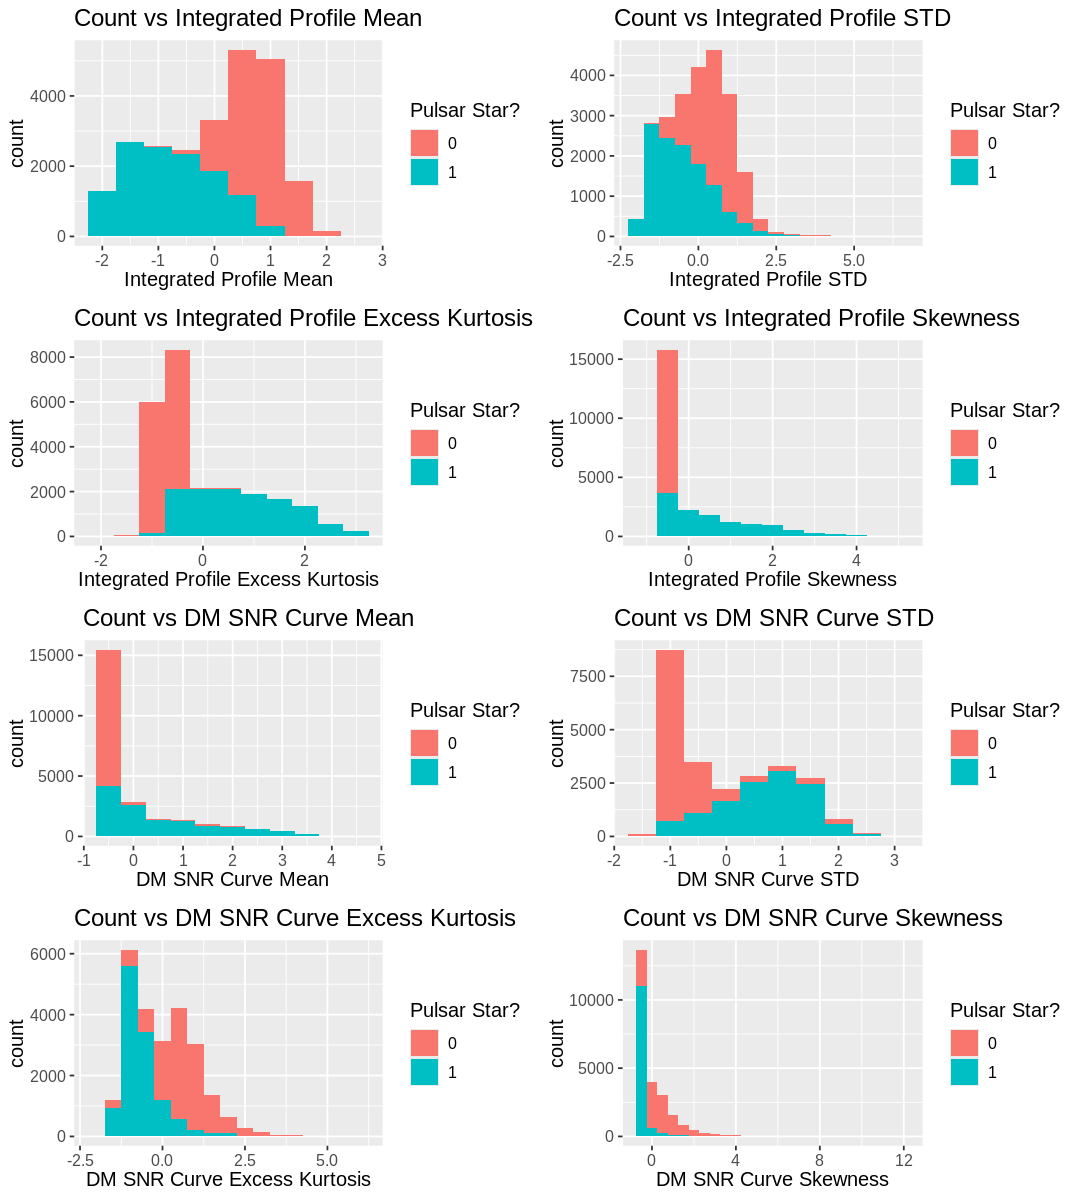

In [6]:
options(repr.plot.width = 9, repr.plot.height = 10)

integrated_profile_mean_graph <- balanced_star |>
    ggplot(aes(x = integrated_profile_mean, fill = is_pulsar_star)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "Integrated Profile Mean", fill = "Pulsar Star?", title = "Count vs Integrated Profile Mean") +
    theme(text = element_text(size = 12))  

integrated_profile_std_graph <- balanced_star |>
    ggplot(aes(x = integrated_profile_std, fill = is_pulsar_star)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "Integrated Profile STD", fill = "Pulsar Star?", title = "Count vs Integrated Profile STD") +
    theme(text = element_text(size = 12))  

integrated_profile_excess_kurtosis_graph <- balanced_star |>
    ggplot(aes(x = integrated_profile_excess_kurtosis, fill = is_pulsar_star)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "Integrated Profile Excess Kurtosis", fill = "Pulsar Star?", title = "Count vs Integrated Profile Excess Kurtosis") +
    theme(text = element_text(size = 12))   

integrated_profile_skewness_graph <- balanced_star |>
    ggplot(aes(x = integrated_profile_skewness, fill = is_pulsar_star)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "Integrated Profile Skewness", fill = "Pulsar Star?", title = "Count vs Integrated Profile Skewness") +
    theme(text = element_text(size = 12))  

dm_snr_curve_mean_graph <- balanced_star |>
    ggplot(aes(x = dm_snr_curve_mean, fill = is_pulsar_star)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "DM SNR Curve Mean", fill = "Pulsar Star?", title = "Count vs DM SNR Curve Mean") +
    theme(text = element_text(size = 12))  

dm_snr_curve_std_graph <- balanced_star |>
    ggplot(aes(x = dm_snr_curve_std, fill = is_pulsar_star)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "DM SNR Curve STD", fill = "Pulsar Star?", title = "Count vs DM SNR Curve STD") +
    theme(text = element_text(size = 12))  

dm_snr_curve_excess_kurtosis_graph <- balanced_star |>
    ggplot(aes(x = dm_snr_curve_excess_kurtosis, fill = is_pulsar_star)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "DM SNR Curve Excess Kurtosis", fill = "Pulsar Star?", title = "Count vs DM SNR Curve Excess Kurtosis") +
    theme(text = element_text(size = 12))  

dm_snr_curve_skewness_graph <- balanced_star |>
    ggplot(aes(x = dm_snr_curve_skewness, fill = is_pulsar_star)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "DM SNR Curve Skewness", fill = "Pulsar Star?", title = "Count vs DM SNR Curve Skewness") +
    theme(text = element_text(size = 12))  

grid.arrange(integrated_profile_mean_graph, 
             integrated_profile_std_graph, 
             integrated_profile_excess_kurtosis_graph, 
             integrated_profile_skewness_graph, 
             dm_snr_curve_mean_graph, 
             dm_snr_curve_std_graph, 
             dm_snr_curve_excess_kurtosis_graph, 
             dm_snr_curve_skewness_graph,
             ncol = 2)

**Figure 1:** Plots of Distribution of Variable

### Building and Training Our Classifier Model 

From the figures above, we can find that some variables have distinct characteristics that may be able to determine whether or not it is a pulsar. This is because there are different trends in the distribution of pulsars that can be visualized on the graphs, such as the integrated profile excess kurtosis and the DM SNR curve std. Therefore, we are going to analyze this research question: ***Can the integrated profile excess kurtosis and DM SNR curve STD predict whether a pulsar star candidate is a pulsar star?***

To do this, we are going to use the nearest_neighbor() function for building our classifier and utilized cross-validation with tune() to determine the best K-value for accurate analysis. Scaling variables was essential to ensure equitable distance calculations among predictors. Due to errors encountered when incorporating the step_upsample function into our recipe for tuning, we opted for manual upsampling before splitting the data. Additionally, we used the vfold() function to create a 5-fold validation set, balancing computational efficiency and statistical significance. Our choice of 5 folds was driven by computational constraints, with higher fold counts proving inefficient for our large dataset. We will try to find out the best k which shows the highest accuracy, supported by a plot illustrating the peak K-value. Armed with the optimal K-value, we then will train our classification model on the train data, enabling predictions on the test data and subsequent construction of the confusion matrix.


In [7]:
set.seed(21)
pulsar_vfold <- vfold_cv(star_training, v = 5, strata = is_pulsar_star)

stars_recipe <- recipe(is_pulsar_star ~ dm_snr_curve_std + integrated_profile_excess_kurtosis, data = balanced_star) |> 
      prep()
     

# Create KNN for tuning k
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

# create KNN Results
gridvals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

knn_predicts <-  workflow() |>
                add_recipe(stars_recipe) |>
                add_model(knn_tune) |>
                tune_grid(resamples = pulsar_vfold, grid = gridvals) |>
                collect_metrics() |>
                filter(.metric == "accuracy")
knn_predicts

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9655817,5,0.001068390,Preprocessor1_Model01
2,accuracy,binary,0.9655817,5,0.001068390,Preprocessor1_Model02
3,accuracy,binary,0.9765334,5,0.001926541,Preprocessor1_Model03
4,accuracy,binary,0.9765334,5,0.001926541,Preprocessor1_Model04
5,accuracy,binary,0.9757884,5,0.001860560,Preprocessor1_Model05
6,accuracy,binary,0.9757884,5,0.001860560,Preprocessor1_Model06
7,accuracy,binary,0.9764589,5,0.001850922,Preprocessor1_Model07
8,accuracy,binary,0.9764589,5,0.001850922,Preprocessor1_Model08
9,accuracy,binary,0.9772039,5,0.001928127,Preprocessor1_Model09


**Table 5:** Model Accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.9784703,5,0.001858715,Preprocessor1_Model21


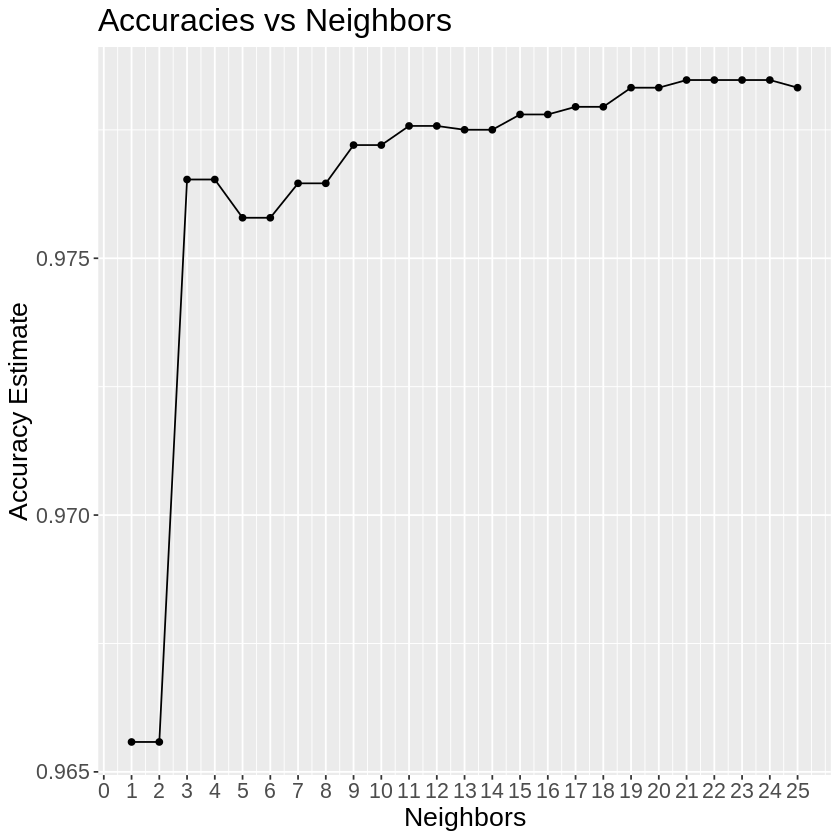

In [8]:
set.seed(21)  

options(repr.plot.width = 7, repr.plot.height = 7)

# Finding the number of neighbors that yields the highest accuracy (mean)
k_max <- knn_predicts |>
    arrange(desc(mean)) |> 
    slice(1)
k_max

# Plotting accuracy against neighbors
accuracies_vs_k  <- ggplot(knn_predicts, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       ggtitle('Accuracies vs Neighbors') +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 25, 1)) + 
       theme(text = element_text(size = 16))
accuracies_vs_k

**Figure 2:**  *The figure is displaying the estimated accuracy vs the number of neighbors used for the analysis. The figure shows an increasing accuracy estimate as the number of neighbors is increased.*

From the Figure 2, We can see that there is a strong transition at k = 3, after which the data fluctuates slightly and stays flat, so we choose k = 3 as our most appropriate option for k. By knowing the appropriate K-value, we were then able to specify our classification model for our train data. Through this, we were eventually able to make predictions for the test data, which allowed us to configure our confusion matrix. We then illustrated the matrix using a four-fold plot, and found the number of observations our classifier correctly labeled as pulsar.

In [11]:
set.seed(21)  

k_best <- 3

# Specifying model using best number of neighbors
star_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_best) |>
  set_engine("kknn") |>
  set_mode("classification")
 
# Fitting our model to the training data
star_fit <- workflow() |>
  add_recipe(stars_recipe) |>
  add_model(star_spec) |>
  fit(data = star_training)
 
# Evaluating our model with the testing data
star_predictions <- star_fit |>
  predict(star_testing) |>
  bind_cols(star_testing) |>
  metrics(truth = is_pulsar_star, estimate = .pred_class) |>
  filter(.metric == 'accuracy')
star_predictions

star_matrix <- star_fit |>
    predict(star_testing) |>
    bind_cols(star_testing) |>
    conf_mat(truth = is_pulsar_star, estimate = .pred_class)
star_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.978324


          Truth
Prediction    0    1
         0 4025   67
         1   30  353

**Table 6:** Confusion Matrix

We can see from the table above that the accuracy is 97% which is very high. As we can see from this confusion matrix table, there were 4025 True Negatives and 353 True positivies. This means that at all the data points, the model predicted 4378 points correctly. With 30 False Positives and 67 False Negatives, that means that the model only made 97 wrong predictions. This is a good one to show that a k nearest neighbors model performs well in this type of dataset.

# Discussion

### Answering the predictive question

Our predictive question is, "Can the integrated profile excess kurtosis and DM SNR curve STD predict whether a pulsar star candidate is a pulsar star?" To answer this question, we made a classifier that determines whether a pulser star candidate is a pulsar star by integrated profile excess kurtosis and DM SNR curve STD.

According to Figure 1, we can see that the two variables, integrated profile excess kurtosis and DM SNR curve STD, are good predictors of whether a pulsar signal is real or not because our histogram shows a clear classification. From our histogram, we can see that the false signals are all concentrated in the part where the integrated profile excess kurtosis is small. As the integrated profile excess kurtosis becomes larger, the pulsar signal is almost all real, and the same is true for the DM SNR curve STD, as well as the DM SNR curve STD. The real pulsar signals are all concentrated in the part where the DM SNR curve STD is larger.

### Expected result vs actual outcomes

We predict that the results obtained with our classifier should be of high accuracy, which should be at least greater than 80%, in order to show that our classifier can be applied in practice. The accuracy of the classifier is important because it involves the probability of our estimation of whether or not the detected signals come from a real pulsar or not.

According to our calculations, we found that our accuracy is 97%, which shows that our classifier has a high accuracy and high utility, and it can work effectively in practical applications. We can think that the small inaccuracy is because the signal of the real pulsar star we found in this data set is too small compared to the false candidates. We can think that the small inaccuracy is due to the fact that in this data set, we found too few real pulsar star signals compared to other signals, which leads to a small error between the predicted data and the actual data used for the test. The way to improve the accuracy is to expand the data set to include enough real pulsar star signals, so as to make our model more accurate.

For the choice of k in our knn model, through Figure 2, we can find that the accuracy of k starts to increase abruptly at 3, and after 3 it starts to fluctuate slightly and then tends to stabilize gradually. The highest accuracy is k = 19, but we can see from the figure that when k = 19, there are too many interfering signals, and the line graph has already stabilized, so we think that k = 3 is the best.

### Impact of our findings

Having a highly accurate classifier allows us to predict which data are real pulsar signals and which are interfering signals when we are detecting the signals, so we can save a lot of time in the actual detection and make our detection more efficient.

### Several questions that it could be lead to

1. How can we make our classifier more accurate?
2. What other variables can we choose to improve our model?


# References

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach MNRAS, 2016. https://doi.org/10.24432/C5DK6R.

Keith, M.J., Jameson, A., Straten, W.V., Bailes, M., Johnston, S., Kramer, M., Possenti, A., Bates, S., Bhat, N.D., Burgay, M., Burke-Spolaor, S., DAmico, N., Levin, L.A., McMahon, P.L., Milia, S., & Stappers, B.W. (2010). The High Time Resolution Universe Pulsar Survey - I. System configuration and initial discoveries. Journal of Leukocyte Biology.

Dr Robert Lyon, University of Manchester, School of Physics and Astronomy, Alan Turing Building, Manchester M13 9PL, United Kingdom, robert.lyon '@' manchester.ac.uk

Skelly, C. (2017). NASA Continues to Study Pulsars, 50 Years After Their Chance Discovery. NASA. https://www.nasa.gov/feature/goddard/2017/nasa-continues-to-study-pulsars-50-years-after-their-chance-discovery